<code>create_model_SIE_anoms.ipynb</code>.  This notebook calculates the anomalous sea ice extent for S2S model forecasts.

This notebook prepares our S2S sea ice extent forecast data for McGraw et al (2021).  Here, we read in sea ice extent data from the following S2S model reforecasts, available from the SIPN portal:
<li> ecmwf </li>
<li> ukmo </li>
<li> metreofr </li>
<li> ncep </li>

For each model, we import the reforecasts that fall within our common reforecast period* (1/1/1999 through 12/31/2014). Next, we calculate a lead-dependent sea ice climatology, $SIE_{clim}$, 

$$SIE_{clim}(l, doy) = \frac{1}{N} \cdot \sum_{i=1}^{N} SIE_{clim}(l,doy,i),$$

where $l$ is the forecast lead time, $doy$ is the day of year, $i$ indicates the year of the forecast (so the forecast date is the day of the year and the year), and $N$ is the number of forecast years. This approach is commonly used for S2S forecast models (see the description in Sun et al. (2018): https://journals.ametsoc.org/mwr/article/146/5/1601/104172/Subseasonal-Forecasting-with-an-Icosahedral, Section 2, paragraphs 2-3 in particular). 

Finally, we estimate the anomalous SIE for each forecast by removing the climatological SIE from the actual SIE,

$$SIE_{anom}(l, doy, i) = SIE(l, doy, i) - SIE_{clim}(l, doy)$$

We output $SIE$, $SIE_{clim}$, and $SIE_{anom}$ to a dataframe. 

**Note that the NCEP reforecasts only go until 2011, so we use the entire NCEP reforecast period

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from S2S_sea_ice_preprocess import load_model, create_aggregate_regions, create_model_climatology
#from S2S_sea_ice_preprocess import create_model_climatology_ROLLING, 

## Functions

<li>1) <code>load_model</code> loads model netCDF files from SIPN, and trims to common reforecast period. (<i> if the model is NCEP, we use the whole period)</i> </li>
<li> 2) <code>create_aggregate_regions</code> Combine some of the NSIDC MASIE regions together for simplicity (e.g., Kara and Laptev Seas combined to create Kara-Laptev Sea region) </li>
<li> 3) <code>create_model_climatology</code>: calculate date of year for valid date, lead time in weeks.
 
  *  Group by region, lead time, and valid date of year 
  *  Average climatology based on day of year and lead time in weeks--use <code>transform</code> to create <code>SIE_clim</code>. 
  *  Subtract <code>SIE_clim</code> from <code>SIE</code> </li>

In [4]:
model_name = 'ukmo'
WEEKLY = True
lead_weeks = True

Load model output for our desired model using xarray

In [5]:
SIE = load_model(model_name)
print('loaded ',model_name)

<xarray.Dataset>
Dimensions:       (ensemble: 6, fore_time: 60, init_time: 1008, nregions: 15)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * fore_time     (fore_time) timedelta64[ns] 0 days 1 days ... 58 days 59 days
  * ensemble      (ensemble) int32 0 1 2 3 4 5
  * init_time     (init_time) datetime64[ns] 1995-01-01 ... 2015-12-25
Data variables:
    Extent        (ensemble, init_time, fore_time, nregions) float64 dask.array<chunksize=(6, 1, 60, 15), meta=np.ndarray>
loaded  ukmo


Create aggregate regions that combine some of the NSIDC-MASIE regions

In [6]:
SIE = create_aggregate_regions(SIE)
print('combined regions')

combined regions


Now, take the ensemble mean and get lead time in days

In [7]:
SIE_ens_mean = SIE.mean(dim='ensemble')
regions = SIE.region_names
lead_days = SIE.fore_time.dt.days

Convert to dataframe because I like Pandas

In [8]:
SIE_df = SIE_ens_mean.to_dataframe().reset_index()

Calculate the date for forecasts by adding the <code>fore_time</code> to <code>init_time</code>. Rename some columns to make life easier

In [9]:
SIE_df['valid date'] = SIE_df['init_time'] + SIE_df['fore_time']
SIE_df = SIE_df.rename(columns={'region_names':'region',
                           'fore_time':'lead time (days)',
                           'init_time':'init date',
                           'Extent':'SIE'})

Create climatology for model output.  Decide how long we want weeks to be for weekly climatology (default is 7 days)

In [12]:
week_length = 7
SIE_df = create_model_climatology(SIE_df,7)

Quick plot to make sure everything looks ok

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


Text(0.5, 1.0, 'sea ice extent, ukmo')

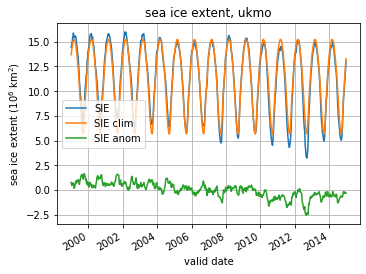

In [23]:
fig1 = plt.figure(1)
ax1 = fig1.add_axes([0,0,0.7,0.7])
SIE_df.set_index(['region','lead time (days)']).xs(('panArctic','1 days')).plot(ax=ax1,x='valid date',
                                                                                y=['SIE','SIE clim','SIE anom'])
ax1.grid()
ax1.set_xlabel('valid date')
ax1.set_ylabel('sea ice extent (10$^6$ km$^2$)')
ax1.set_title('sea ice extent, {model}'.format(model=model_name))
#plt.close()

Save everything in a dataframe

In [25]:
fpath_save = '../DATA/'
if not os.path.exists(fpath_save):
    os.makedirs(fpath_save)
fname_save = fpath_save+'SIE_S2S_model_forecasts_COMMON_REFORECAST.csv'
#SIE_df.to_csv(fname_save)